In [3]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import glob

from sklearn import decomposition
from sklearn.neighbors import KernelDensity
from sklearn.manifold import TSNE

matplotlib.style.use('fivethirtyeight')

In [83]:
maleFaceFiles = glob.glob("../data/fifa/Pictures/*.png")

femaleFaceFiles = glob.glob("../data/fifa/Pictures_f/*.png")

faceFiles = maleFaceFiles + femaleFaceFiles

listOfPlayerNames = []
listOfImages = []

for imageFileName in faceFiles:
  
    currName = imageFileName.split("/")[-1].split(".")[0].split("\\")[-1]

    try:
        currImage = mpimg.imread(imageFileName)
        if len(np.unique(currImage[:,:,0].ravel()))<=40:
            print("No Image for '"+currName+"'")
            
        else:
            listOfPlayerNames.append(currName)
            listOfImages.append(currImage)
            
    except:
        print("didnt load "+currName)
        
femaleNames = [x.split("/")[-1].split(".")[0].split("\\")[-1] for x in femaleFaceFiles]
isFemale    = [x in femaleNames for x in listOfPlayerNames]
print("Total number of loaded face images is %d" %(len(listOfImages)))

Total number of loaded face images is 572


In [13]:
# show random sample

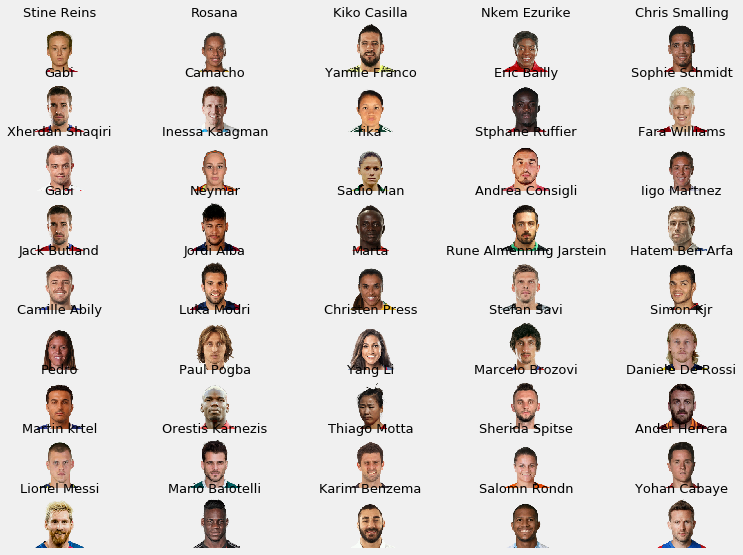

In [14]:
matplotlib.rcParams['font.size']=9
matplotlib.rcParams['figure.figsize']=(12,9)

numRows =9
numCols =5

plt.figure()

for k in range(numRows * numCols):
    randInd = np.random.randint(len(listOfImages))
    plt.subplot(numRows,numCols,k+1)
    plt.imshow(listOfImages[randInd])
    plt.title(listOfPlayerNames[randInd])
    plt.axis('off')
    
    

In [ ]:
# reorganize data

In [22]:
# gather evrything into a large matrix
fullImageMatrix4D = np.zeros((128,128,3,len(listOfImages)))

backgroundImage = np.zeros((128,128,3))
backgroundImage[:,:,0]=0.3
backgroundImage[:,:,1]=0.4
backgroundImage[:,:,2]=0.5

for k, currImage in enumerate(listOfImages):
    alphaChannel = currImage[:,:,3]
    rgbImage = currImage[:,:,:3]
    tiledAlpha = np.tile(alphaChannel[:,:,np.newaxis],(1,1,3))
    fullImageMatrix4D[:,:,:,k] =rgbImage*tiledAlpha + (tiledAlpha < 0.15) * backgroundImage


In [23]:
# Show the Mean Face Image and pixel-wise Standard Deviation Image

(-0.5, 127.5, 127.5, -0.5)

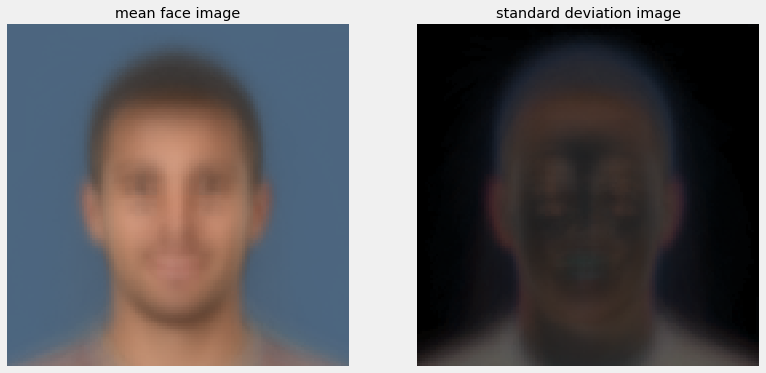

In [24]:
matplotlib.rcParams['font.size']=10
matplotlib.rcParams['figure.figsize'] = (12,12)

plt.figure();
plt.subplot(1,2,1);plt.imshow(fullImageMatrix4D.mean(axis=3));
plt.title("mean face image");plt.axis("off")
plt.subplot(1,2,2);plt.imshow(fullImageMatrix4D.std(axis=3));
plt.title('standard deviation image');plt.axis("off")

In [ ]:
# build gaussian model

In [28]:
#%% define GaussianModel class and some additional helper functions

class GaussianModel:

    def __init__(self, X, numBasisFunctions=10, objectPixels=None):
        '''
        inputs: 
            X                    - numSamples x numDimentions matrix
            numBasisFunctions       - number of basis function to use
            objectPixels (optional) - an binnary mask image used for presentation
                                      will be used as Im[objectPixels] = dataSample
                                      must satisfy objectPixels.ravel().sum() = X.shape[1]
        '''
        
        self.numBasisFunctions = numBasisFunctions
        if objectPixels is None:
            self.objectPixels = np.ones((1,X.shape[1]),dtype=np.bool)
        else:
            self.objectPixels = objectPixels
        assert(self.objectPixels.ravel().sum() == X.shape[1])

        PCAModel = decomposition.PCA(n_components=numBasisFunctions, whiten=True)
        #PCAModel = decomposition.IncrementalPCA(n_components=numBasisFunctions, whiten=True, batch_size=400)
        self.dataRepresentation = PCAModel.fit_transform(X)
        self.PCAModel = PCAModel

        
    def RepresentUsingModel(self, X):
        return self.PCAModel.transform(X)

    def ReconstructUsingModel(self, X_transformed):
        return self.PCAModel.inverse_transform(X_transformed)

    def InterpretUsingModel(self, X):
        return self.PCAModel.inverse_transform(self.PCAModel.transform(X))

        
    # shows the eigenvectors of the gaussian covariance matrix
    def ShowVarianceDirections(self, numDirectionsToShow=16):
        #matplotlib.rcParams['font.size'] = 14
        numDirectionsToShow = min(numDirectionsToShow, self.numBasisFunctions)
        
        numFigRows = 4; numFigCols = 4;
        numDirectionsPerFigure = numFigRows*numFigCols
        numFigures = int(np.ceil(float(numDirectionsToShow)/numDirectionsPerFigure))
        
        for figureInd in range(numFigures):
            plt.figure()
            for plotInd in range(numDirectionsPerFigure):
                eigVecInd = numDirectionsPerFigure*figureInd + plotInd
                if eigVecInd >= self.numBasisFunctions:
                    break
                deltaImage = np.zeros(np.shape(self.objectPixels))
                deltaImage[self.objectPixels] = self.PCAModel.components_[eigVecInd,:].ravel()

                plt.subplot(numFigRows,numFigCols,plotInd+1)
                if np.shape(self.objectPixels)[0] == 1:
                    plt.plot(deltaImage)
                elif np.shape(self.objectPixels)[2] == 3:
                    deltaImage = 0.1/deltaImage.std()*deltaImage+0.5
                    deltaImage[deltaImage>1] = 1.0
                    deltaImage[deltaImage<0] = 0.0
                    plt.imshow(deltaImage); plt.axis('off')
                else:
                    plt.imshow(deltaImage); plt.axis('off')
                plt.title('%.3f%s explained' %(100*self.PCAModel.explained_variance_ratio_[eigVecInd], '%'))
            plt.tight_layout()

    
    # shows several random model reconstructions
    def ShowReconstructions(self, X, numReconstructions=6):
        #matplotlib.rcParams['font.size'] = 14
        assert(np.shape(X)[1] == self.objectPixels.ravel().sum())
        numSamples = np.shape(X)[0]
        numReconstructions = min(numReconstructions, numSamples)
        
        originalImage      = np.zeros(np.shape(self.objectPixels))
        reconstructedImage = np.zeros(np.shape(self.objectPixels))
        
        numReconstructionsPerFigure = min(6, numReconstructions)
        numFigures = int(np.ceil(float(numReconstructions)/numReconstructionsPerFigure))
        
        for figureInd in range(numFigures):
            plt.figure()
            for plotCol in range(numReconstructionsPerFigure):
                dataSampleInd = np.random.randint(numSamples)
                originalImage[self.objectPixels] = X[dataSampleInd,:].ravel()
                reconstructedImage[self.objectPixels] = self.InterpretUsingModel(np.reshape(X[dataSampleInd,:],[1,-1])).ravel()
                diffImage = abs(originalImage - reconstructedImage)
                
                # original image
                plt.subplot(3,numReconstructionsPerFigure,0*numReconstructionsPerFigure+plotCol+1)
                if np.shape(self.objectPixels)[0] == 1:
                    plt.plot(originalImage); plt.title('original signal')
                else:
                    plt.imshow(originalImage, cmap='gray'); plt.title('original image'); plt.axis('off')
                    
                # reconstred image
                plt.subplot(3,numReconstructionsPerFigure,1*numReconstructionsPerFigure+plotCol+1)
                if np.shape(self.objectPixels)[0] == 1:
                    plt.plot(reconstructedImage); plt.title('reconstructed signal')
                elif np.shape(self.objectPixels)[2] == 3:
                    reconstructedImage[reconstructedImage>1] = 1.0
                    reconstructedImage[reconstructedImage<0] = 0.0
                    plt.imshow(reconstructedImage); plt.title('reconstructed image'); plt.axis('off')
                else:
                    plt.imshow(reconstructedImage, cmap='gray'); plt.title('reconstructed image'); plt.axis('off')

                # diff image
                plt.subplot(3,numReconstructionsPerFigure,2*numReconstructionsPerFigure+plotCol+1)
                if np.shape(self.objectPixels)[0] == 1:
                    plt.plot(diffImage); plt.title('abs difference signal')
                else:
                    plt.imshow(diffImage, cmap='gray'); plt.title('abs difference image'); plt.axis('off')
            plt.tight_layout()

            
    # shows distrbution along the variance directions and several images along that variance direction
    def ShowModelVariations(self, numVariations=6):
        #matplotlib.rcParams['font.size'] = 14

        showAsTraces = (np.shape(self.objectPixels)[0] == 1)
        numVariations = min(numVariations, self.numBasisFunctions)
                
        numVarsPerFigure = min(6,numVariations)
        numFigures = int(np.ceil(float(numVariations)/numVarsPerFigure))
        
        lowRepVec     = np.percentile(self.dataRepresentation, 2, axis=0)
        medianRepVec  = np.percentile(self.dataRepresentation, 50, axis=0)
        highRepVec    = np.percentile(self.dataRepresentation, 98, axis=0)

        for figureInd in range(numFigures):
            plt.figure()
            for plotCol in range(numVarsPerFigure):
                eigVecInd = numVarsPerFigure*figureInd+plotCol
                if eigVecInd >= self.numBasisFunctions:
                    break

                # create the low and high precentile representation activation vectors
                currLowPrecentileRepVec             = medianRepVec.copy()
                currLowPrecentileRepVec[eigVecInd]  = lowRepVec[eigVecInd]
                currHighPrecentileRepVec            = medianRepVec.copy()
                currHighPrecentileRepVec[eigVecInd] = highRepVec[eigVecInd]

                # create blank images
                deltaImage          = np.zeros(np.shape(self.objectPixels))
                medianImage         = np.zeros(np.shape(self.objectPixels))
                lowPrecentileImage  = np.zeros(np.shape(self.objectPixels))
                highPrecentileImage = np.zeros(np.shape(self.objectPixels))

                # fill the object pixels with the relevant data
                deltaImage[self.objectPixels]          = self.PCAModel.components_[eigVecInd,:].ravel()
                lowPrecentileImage[self.objectPixels]  = self.ReconstructUsingModel(currLowPrecentileRepVec).ravel()
                medianImage[self.objectPixels]         = self.ReconstructUsingModel(medianRepVec).ravel()
                highPrecentileImage[self.objectPixels] = self.ReconstructUsingModel(currHighPrecentileRepVec).ravel()

                # calculate the Gaussian smoothed distribution of values along the eignevector direction
                sigmaOfKDE = 0.12
                pdfStart   = min(self.dataRepresentation[:,eigVecInd]) - 3*sigmaOfKDE
                pdfStop    = max(self.dataRepresentation[:,eigVecInd]) + 3*sigmaOfKDE
                xAxis = np.linspace(pdfStart,pdfStop,200)
                PDF_Model = KernelDensity(kernel='gaussian', bandwidth=sigmaOfKDE).fit(self.dataRepresentation[:,eigVecInd].reshape(-1,1))
                logPDF = PDF_Model.score_samples(xAxis.reshape(-1,1))

                # show distribution of current component 
                plt.subplot(5,numVarsPerFigure,0*numVarsPerFigure+plotCol+1)
                plt.fill(xAxis, np.exp(logPDF), fc='b', alpha=0.9);
                plt.title('%.3f%s explained' %(100*self.PCAModel.explained_variance_ratio_[eigVecInd], '%'))
                
                # show variance direction (eigenvector)
                plt.subplot(5,numVarsPerFigure,1*numVarsPerFigure+plotCol+1);
                if showAsTraces:
                    plt.plot(deltaImage); plt.title('eigenvector ' + str(eigVecInd))
                elif np.shape(self.objectPixels)[2] == 3:
                    deltaImage = 0.1/deltaImage.std()*deltaImage+0.5
                    deltaImage[deltaImage>1] = 1.0
                    deltaImage[deltaImage<0] = 0.0
                    plt.imshow(deltaImage); plt.title('eigenvector ' + str(eigVecInd)); plt.axis('off')
                else:
                    plt.imshow(deltaImage); plt.title('eigenvector ' + str(eigVecInd)); plt.axis('off')

                # show 2nd precentile image
                plt.subplot(5,numVarsPerFigure,2*numVarsPerFigure+plotCol+1)
                if showAsTraces:
                    plt.plot(lowPrecentileImage); plt.title('2nd precentile')
                elif np.shape(self.objectPixels)[2] == 3:
                    lowPrecentileImage[lowPrecentileImage>1] = 1.0
                    lowPrecentileImage[lowPrecentileImage<0] = 0.0
                    plt.imshow(lowPrecentileImage); plt.title('2nd precentile'); plt.axis('off')
                else:
                    plt.imshow(lowPrecentileImage, cmap='gray'); plt.title('2nd precentile'); plt.axis('off')

                # show median image
                plt.subplot(5,numVarsPerFigure,3*numVarsPerFigure+plotCol+1)
                if showAsTraces:
                    plt.plot(medianImage); plt.title('median')
                else:
                    plt.imshow(medianImage, cmap='gray'); plt.title('median'); plt.axis('off')

                # show 98th precentile image
                plt.subplot(5,numVarsPerFigure,4*numVarsPerFigure+plotCol+1)
                if showAsTraces:
                    plt.plot(highPrecentileImage); plt.title('98th precentile')
                elif np.shape(self.objectPixels)[2] == 3:
                    highPrecentileImage[highPrecentileImage>1] = 1.0
                    highPrecentileImage[highPrecentileImage<0] = 0.0
                    plt.imshow(highPrecentileImage); plt.title('98th precentile'); plt.axis('off')
                else:
                    plt.imshow(highPrecentileImage, cmap='gray'); plt.title('98th precentile'); plt.axis('off')
            plt.tight_layout()
        
            
    # shows distrbution along the variance directions and several images along that variance direction
    def ShowSingleComponentVariation(self, X, listOfComponents=[0,1]):
        #matplotlib.rcParams['font.size'] = 14

        showAsTraces = (np.shape(self.objectPixels)[0] == 1)
        assert(all([(x in range(self.numBasisFunctions)) for x in listOfComponents]))
                
        X_rep = self.RepresentUsingModel(X)
        
        percentilesToShow = [1,10,30,70,90,99]
        numReadDataSamplePerPercentile = 4
        representationPercentiles = []
        for percentile in percentilesToShow:
            representationPercentiles.append(np.percentile(self.dataRepresentation, percentile, axis=0))
        medianRepVec =  np.percentile(self.dataRepresentation, 50, axis=0)

        for eigVecInd in listOfComponents:
            plt.figure(); gs = gridspec.GridSpec(numReadDataSamplePerPercentile+2,len(percentilesToShow))

            # calculate the Gaussian smoothed distribution of values along the eignevector direction
            sigmaOfKDE = 0.12
            pdfStart   = min(self.dataRepresentation[:,eigVecInd]) - 3*sigmaOfKDE
            pdfStop    = max(self.dataRepresentation[:,eigVecInd]) + 3*sigmaOfKDE
            xAxis = np.linspace(pdfStart,pdfStop,200)
            PDF_Model = KernelDensity(kernel='gaussian', bandwidth=sigmaOfKDE).fit(self.dataRepresentation[:,eigVecInd].reshape(-1,1))
            logPDF = PDF_Model.score_samples(xAxis.reshape(-1,1))
            percentileValuesToShow = [representationPercentiles[x][eigVecInd] for x in range(len(representationPercentiles))]
            percentilesToShowLogPDF = PDF_Model.score_samples(np.array(percentileValuesToShow).reshape(-1,1))

            # show distribution of current component and red dots at the list of precentiles to show 
            plt.subplot(gs[0,:])
            plt.fill(xAxis, np.exp(logPDF), fc='b', alpha=0.9);
            plt.scatter(percentileValuesToShow, np.exp(percentilesToShowLogPDF), c='r',s=300);
            plt.title('%.3f%s explained' %(100*self.PCAModel.explained_variance_ratio_[eigVecInd], '%'))
            
            for plotCol, currPrecentile in enumerate(percentilesToShow):                
                currPrecentileRepVec             = medianRepVec.copy()
                currPrecentileRepVec[eigVecInd]  = representationPercentiles[plotCol][eigVecInd]
                
                currPrecentileImage = np.zeros(np.shape(self.objectPixels))
                currPrecentileImage[self.objectPixels]  = self.ReconstructUsingModel(currPrecentileRepVec).ravel()
                
                # show the median image with current precentile as activation of the curr image
                plt.subplot(gs[1,plotCol]);
                if showAsTraces:
                    plt.plot(currPrecentileImage); plt.title('precentile: ' + str(percentilesToShow[plotCol]) + '%')
                elif np.shape(self.objectPixels)[2] == 3:
                    currPrecentileImage[currPrecentileImage>1] = 1.0
                    currPrecentileImage[currPrecentileImage<0] = 0.0
                    plt.imshow(currPrecentileImage); plt.title('precentile: ' + str(percentilesToShow[plotCol]) + '%'); plt.axis('off')
                else:
                    plt.imshow(currPrecentileImage, cmap='gray'); plt.title('precentile: ' + str(percentilesToShow[plotCol]) + '%'); plt.axis('off')

                # find the most suitible candidates in X for current precentile
                distFromPercentile = abs(X_rep[:,eigVecInd] - representationPercentiles[plotCol][eigVecInd])
                X_inds = np.argpartition(distFromPercentile, numReadDataSamplePerPercentile)[:numReadDataSamplePerPercentile]
                for k, X_ind in enumerate(X_inds):
                    currNearestPrecentileImage = np.zeros(np.shape(self.objectPixels))
                    currNearestPrecentileImage[self.objectPixels]  = X[X_ind,:].ravel()
                    
                    plt.subplot(gs[2+k,plotCol]);
                    if showAsTraces:
                        plt.plot(currNearestPrecentileImage); plt.title('Close Neighbor');
                    else:
                        plt.imshow(currNearestPrecentileImage, cmap='gray'); plt.title('Close Neighbor'); plt.axis('off')
            plt.tight_layout()

            
    # show the scatter plot of the first 2 PC components and and approximation of all PC compents scatter using t-SNE 
    def ShowDataScatterPlotsWithTSNE(self, X=None, y=None, colorMap='Paired', pointSize=120, pointAlpha=0.9):
        
        if X is None:
            X_rep = self.dataRepresentation
        else:
            X_rep = self.RepresentUsingModel(X)
            
        if y is None:
            y = np.ones(X_rep.shape[0])
            
        tSNE_PCAModel = TSNE(n_components=2, random_state=0)
        X_rep_tSNE = tSNE_PCAModel.fit_transform(X_rep) 
        
        plt.figure()
        plt.subplot(1,2,1); plt.scatter(X_rep[:,0],X_rep[:,1],c=y,cmap=colorMap,s=pointSize,alpha=pointAlpha)
        plt.title('PCA representation'); plt.xlabel('PC1 coeff'); plt.ylabel('PC2 coeff')
        plt.subplot(1,2,2); plt.scatter(X_rep_tSNE[:,0],X_rep_tSNE[:,1],c=y,cmap=colorMap,s=pointSize,alpha=pointAlpha)
        plt.title('t-SNE representation'); plt.xlabel('t-SNE axis1'); plt.ylabel('t-SNE axis2')
        
        self.tSNE_embedding = tSNE_PCAModel.embedding_

In [30]:
objectPixels = np.ones((np.shape(fullImageMatrix4D)[0],np.shape(fullImageMatrix4D)[1],np.shape(fullImageMatrix4D)[2]))

sampleDim = objectPixels.size

X = fullImageMatrix4D.reshape(sampleDim,-1).T

face_PCAModel = GaussianModel(X, numBasisFunctions=120,objectPixels =(objectPixels==1))

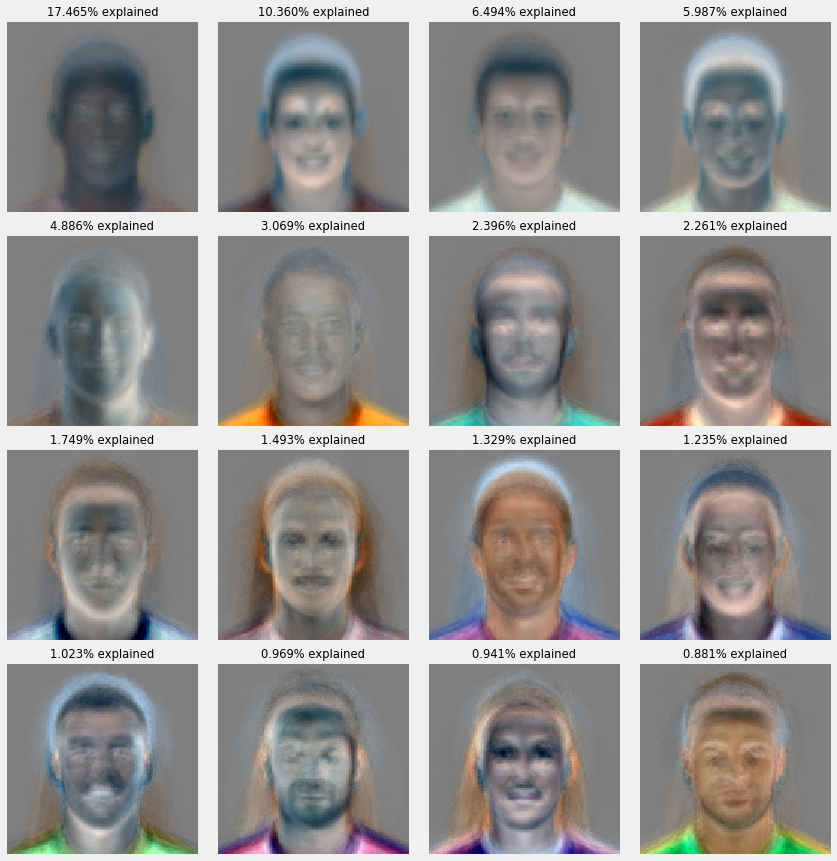

In [34]:
matplotlib.rcParams['font.size'] =8
matplotlib.rcParams['figure.figsize']=(12,12)

face_PCAModel.ShowVarianceDirections(numDirectionsToShow=16)

In [ ]:
# original images reconstruction

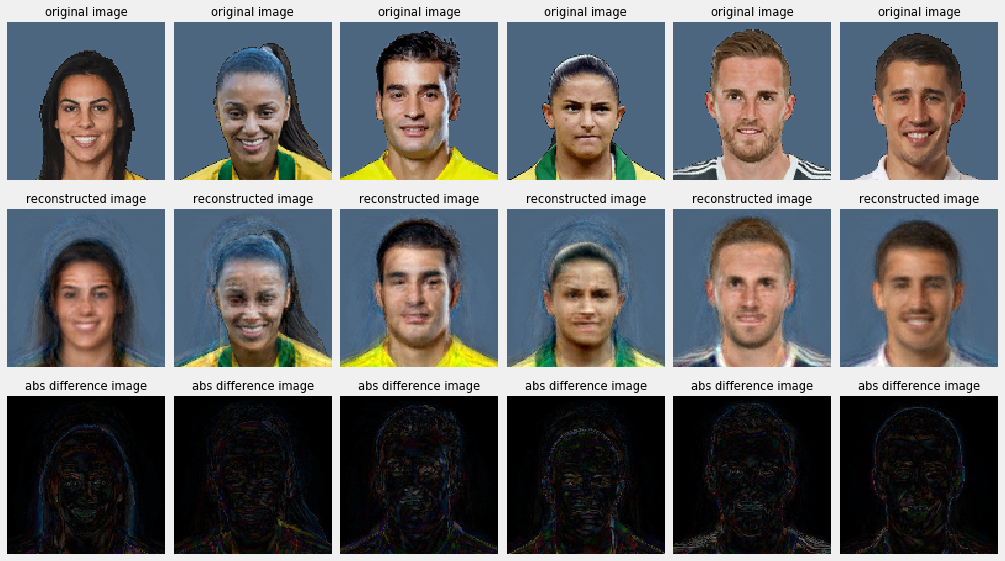

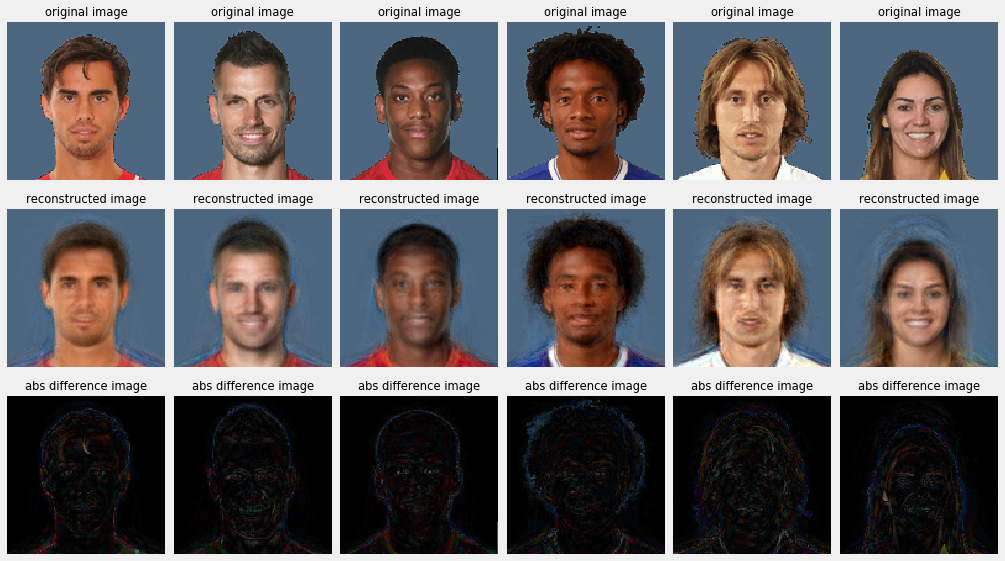

In [35]:
matplotlib.rcParams['font.size'] =8
matplotlib.rcParams['figure.figsize']=(14,8)

face_PCAModel.ShowReconstructions(X, numReconstructions=12)

In [ ]:
# how faces vary from the mean

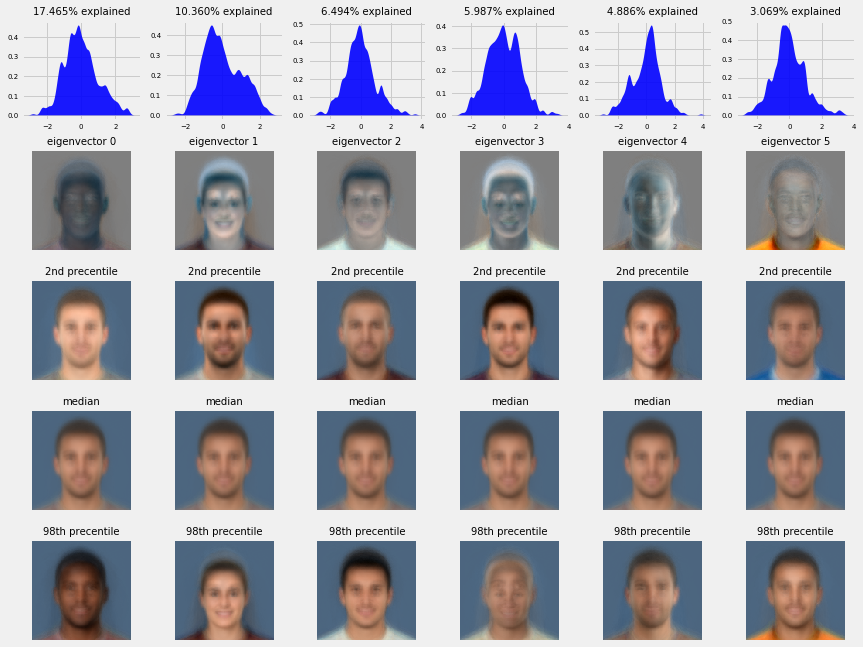

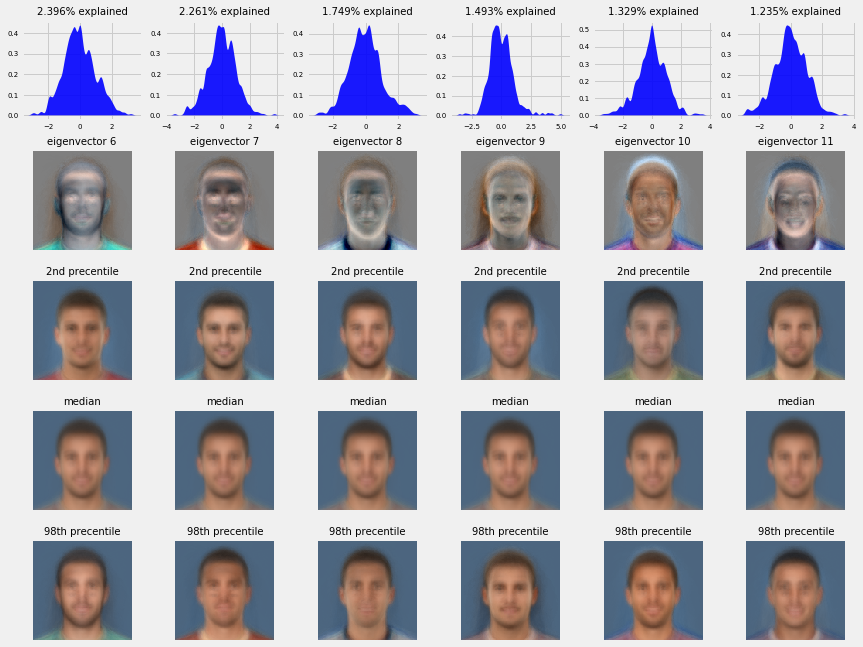

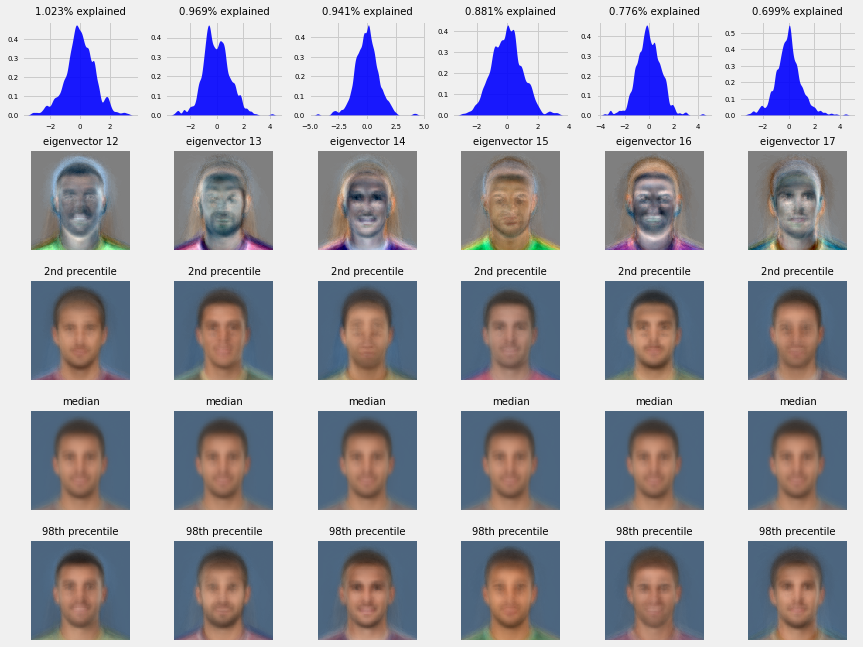

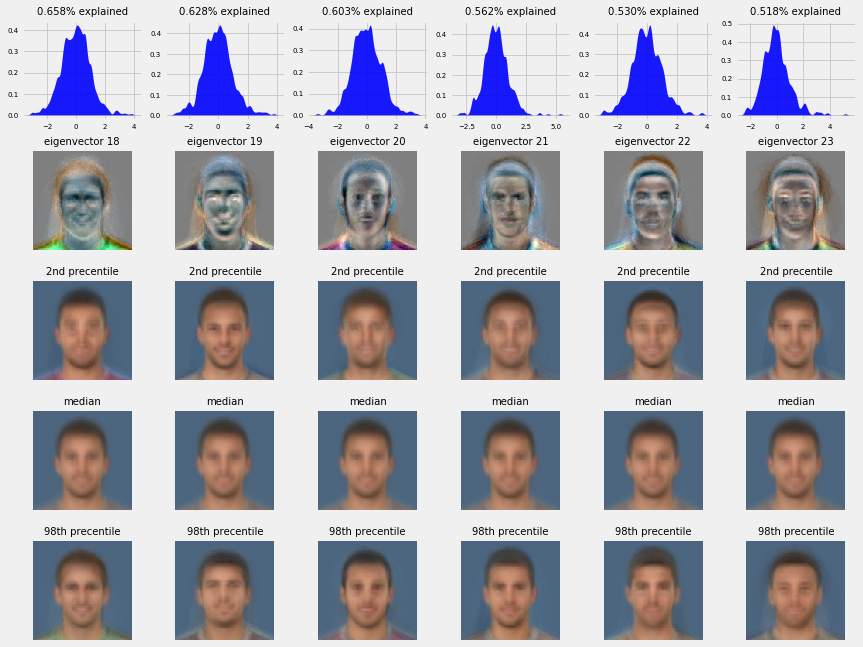

In [39]:
matplotlib.rcParams['font.size']=7
matplotlib.rcParams['figure.figsize']=(12,9)

face_PCAModel.ShowModelVariations(numVariations=20)

In [ ]:
# Eigenvector 1: dark skinned or light skinned?

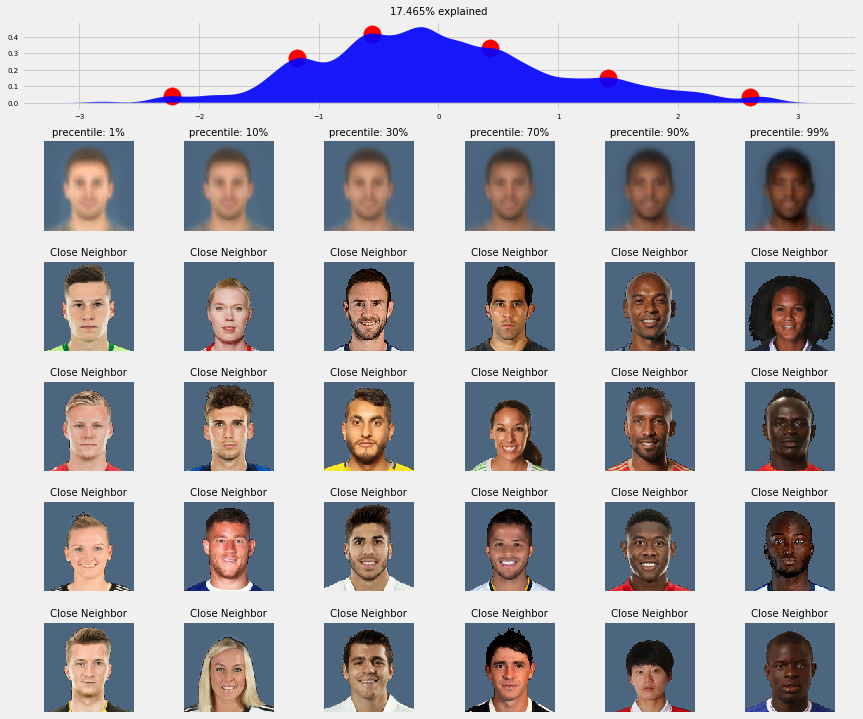

In [37]:
matplotlib.rcParams['font.size']=7
matplotlib.rcParams['figure.figsize']=(12,10)

face_PCAModel.ShowSingleComponentVariation(X, listOfComponents=[0])

In [ ]:
# Eigenvector 2: male or female?

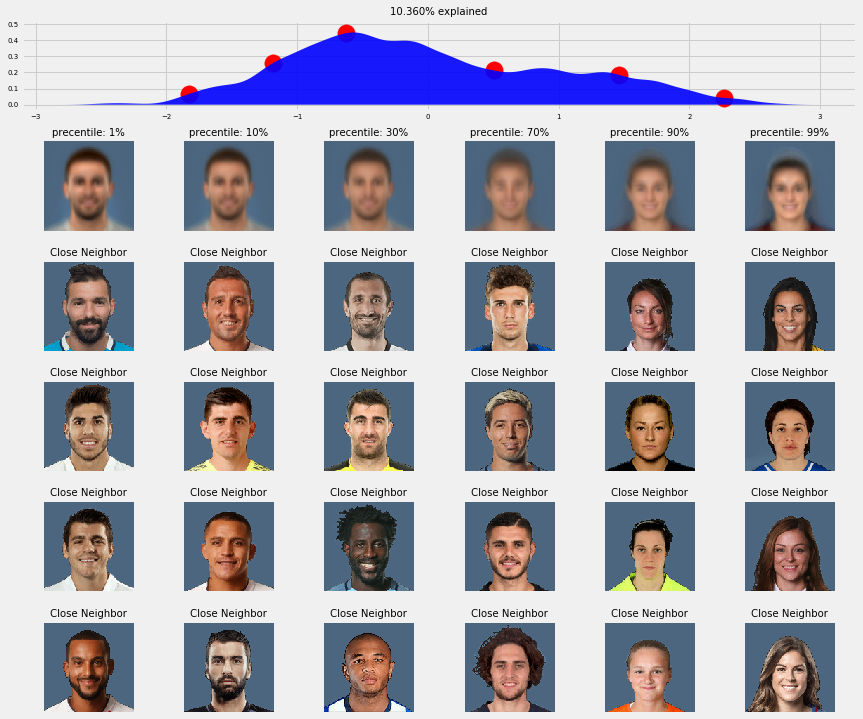

In [38]:
matplotlib.rcParams['font.size']=7
matplotlib.rcParams['figure.figsize']=(12,10)

face_PCAModel.ShowSingleComponentVariation(X, listOfComponents=[1])

In [ ]:
# Eigenvector 11: dim or bright lighting?

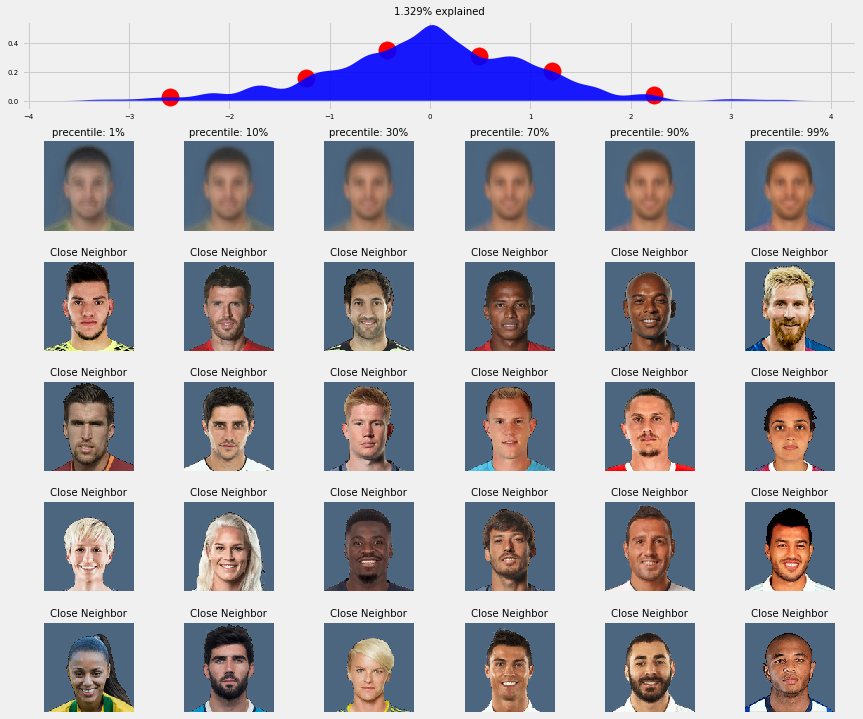

In [40]:
matplotlib.rcParams['font.size'] = 7
matplotlib.rcParams['figure.figsize'] = (12,10)

face_PCAModel.ShowSingleComponentVariation(X, listOfComponents=[10])

In [ ]:
playerData = pd.read_csv("../data/fifa/FullData.csv").drop_duplicates(subset="Name",keep="last").reset_index(drop=True)

listOfAllPlayerNames = playerData['Name'].tolist()

In [67]:
print (len(listOfAllPlayerNames))
print (len(isFemale))
print(len(listOfPlayerNames))

17341
572
572


In [84]:

recordRowInd = [listOfAllPlayerNames.index(x) if x in listOfAllPlayerNames else 'False' for x in listOfPlayerNames]

desiredColumns = ['Name','Nationality','Sex','Age','Height','Weight']
playerWithPicsData = pd.DataFrame(index=range(len(listOfPlayerNames)),columns=desiredColumns)
playerWithPicsData.loc[:,'Name']=[x for x in listOfPlayerNames]
playerWithPicsData.loc[:,'Sex']=['Female' if x  else 'Male' for x in isFemale]
                               

for k,currRowInd in enumerate(recordRowInd):
    if currRowInd != 'False':
        playerWithPicsData.loc[k,'Age']=float(playerData.loc[currRowInd,'Age'])
        playerWithPicsData.loc[k,'Height']=float(playerData.loc[currRowInd,'Height'].split(' ')[0])
        playerWithPicsData.loc[k,'Weight']=float(playerData.loc[currRowInd,'Weight'].split(' ')[0])
        playerWithPicsData.loc[k,'Nationality']=playerData.loc[currRowInd,'Nationality']
        
faceFeatures = face_PCAModel.RepresentUsingModel(X)
        
playerWithPicsData.head(10)


Name Nationality   Sex  Age Height Weight
0        Aaron Ramsey       Wales  Male   26    183     76
1        Adam Lallana     England  Male   28    172     73
2           Adil Rami      France  Male   31    190     88
3                 Adn         NaN  Male  NaN    NaN    NaN
4       Adrien Rabiot      France  Male   21    188     71
5        Adrien Silva    Portugal  Male   28    175     69
6              Aduriz       Spain  Male   36    182     78
7        Alan Dzagoev      Russia  Male   26    179     75
8      Alejandro Gmez         NaN  Male  NaN    NaN    NaN
9  Aleksandar Kolarov      Serbia  Male   31    187     83

In [85]:
print(len(playerWithPicsData[playerWithPicsData['Sex']=='Male']))

432


In [86]:
playerWithPicsData.tail(10)

Name Nationality     Sex  Age Height Weight
562              Thaisa         NaN  Female  NaN    NaN    NaN
563         Tobin Heath         NaN  Female  NaN    NaN    NaN
564   Valentina Cernoia         NaN  Female  NaN    NaN    NaN
565  Valentina Giacinti         NaN  Female  NaN    NaN    NaN
566        Vero Boquete         NaN  Female  NaN    NaN    NaN
567    Vivianne Miedema         NaN  Female  NaN    NaN    NaN
568       Wendie Renard         NaN  Female  NaN    NaN    NaN
569       Whitney Engen         NaN  Female  NaN    NaN    NaN
570       Yamile Franco         NaN  Female  NaN    NaN    NaN
571             Yang Li         NaN  Female  NaN    NaN    NaN

In [87]:
# Plot the correlation between different attributes and the different PCA components¶

Text(0.5, 0.98, 'how different pca correlate with real life attributes')

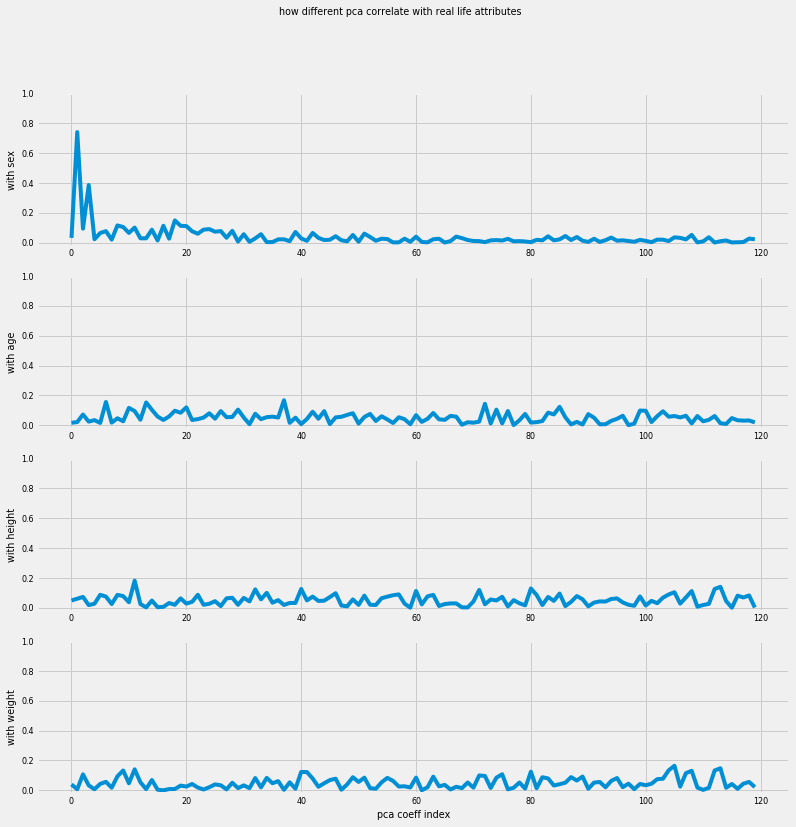

In [88]:
# find the PCA component that most correlates with 'Sex'
relevantCols = np.array(playerWithPicsData.loc[:,'Sex'].notnull())
targetFeature = np.array(playerWithPicsData.loc[relevantCols,'Sex']=='Male')[:,np.newaxis]
corrWithSexVec = np.corrcoef(np.hstack((targetFeature,faceFeatures[relevantCols,:])).T)[0,1:]
mostCorrelatedWithSex = np.argmax(abs(corrWithSexVec))

# find the PCA component that most correlates with 'Age'
relevantCols = np.array(playerWithPicsData.loc[:,'Age'].notnull())
targetFeature = np.array(playerWithPicsData.loc[relevantCols,'Age'].tolist())[:,np.newaxis]
corrWithAgeVec = np.corrcoef(np.hstack((targetFeature,faceFeatures[relevantCols,:])).T)[0,1:]
mostCorrelatedWithAge = np.argmax(abs(corrWithAgeVec))

# find the PCA component that most correlates with 'Height'
relevantCols = np.array(playerWithPicsData.loc[:,'Height'].notnull())
targetFeature = np.array(playerWithPicsData.loc[relevantCols,'Height'].tolist())[:,np.newaxis]
corrWithHeightVec = np.corrcoef(np.hstack((targetFeature,faceFeatures[relevantCols,:])).T)[0,1:]
mostCorrelatedWithHeight = np.argmax(abs(corrWithHeightVec))

# find the PCA component that most correlates with 'Weight'
relevantCols = np.array(playerWithPicsData.loc[:,'Weight'].notnull())
targetFeature = np.array(playerWithPicsData.loc[relevantCols,'Weight'].tolist())[:,np.newaxis]
corrWithWeightVec = np.corrcoef(np.hstack((targetFeature,faceFeatures[relevantCols,:])).T)[0,1:]
mostCorrelatedWithWeight = np.argmax(abs(corrWithWeightVec))

matplotlib.rcParams['font.size']=8
matplotlib.rcParams['figure.figsize']=(12,12)

plt.figure()
plt.subplot(4,1,1);
plt.plot(np.abs(corrWithSexVec))
plt.ylim(-0.02,1);
plt.ylabel('with sex')
plt.subplot(4,1,2);
plt.plot(np.abs(corrWithAgeVec))
plt.ylim(-0.02,1);
plt.ylabel('with age')
plt.subplot(4,1,3);
plt.plot(np.abs(corrWithHeightVec));
plt.ylim(-0.02,1);
plt.ylabel('with height')
plt.subplot(4,1,4);plt.plot(np.abs(corrWithWeightVec));
plt.ylim(-0.02,1);plt.ylabel('with weight')
plt.xlabel('pca coeff index')
plt.suptitle('how different pca correlate with real life attributes')